This project aims to perform a car price prediction, using Simple and Multivariable Linear regression.

The database used can be found on Kaggle following this link : https://www.kaggle.com/CooperUnion/cardataset#data.csv.
It contains more than 11 000 examples of cars sold from 1990 - 2017, and some of their characteristics. 

__Summary__

1. Basic understanding of the data
    - Importing data
    - Statistical description


2. Data Wrangling
    - Dtypes
    - Missing Values


3. Data exploration
    - Categorical variables : box plot
    - Numerical variables : descriptive statistic


4. Model Development
    - Features engineering (transformation & selection)
    - Simple Linear regression
    - Multiple Linear regression
    - Polynomial regression


5. Model Optimisation
    - Correlation and p-value
    - Model testing & evaluation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

__Basic Understanding of the Data__

In [2]:
df = pd.read_csv(r'C:\Users\jguer_gompqqi\OneDrive\Documents\Data Science\Machine Learning\Datasets & Projects\Databases\cars.csv')
df.rename(columns={'MSRP':'Price'}, inplace=True)
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,Price
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [3]:
# The most expensive cars
df.nlargest(5, 'Price')

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,Price
11362,Bugatti,Veyron 16.4,2008,premium unleaded (required),1001.0,16.0,AUTOMATED_MANUAL,all wheel drive,2.0,"Exotic,High-Performance",Compact,Coupe,14,8,820,2065902
11364,Bugatti,Veyron 16.4,2009,premium unleaded (required),1001.0,16.0,AUTOMATED_MANUAL,all wheel drive,2.0,"Exotic,High-Performance",Compact,Coupe,14,8,820,1705769
8486,Lamborghini,Reventon,2008,premium unleaded (required),650.0,12.0,AUTOMATED_MANUAL,all wheel drive,2.0,"Exotic,High-Performance",Compact,Coupe,14,9,1158,1500000
11363,Bugatti,Veyron 16.4,2008,premium unleaded (required),1001.0,16.0,AUTOMATED_MANUAL,all wheel drive,2.0,"Exotic,High-Performance",Compact,Coupe,14,8,820,1500000
6351,Maybach,Landaulet,2012,premium unleaded (required),620.0,12.0,AUTOMATIC,rear wheel drive,4.0,"Exotic,Luxury,Performance",Large,Convertible,16,10,67,1382750


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
Make                 11914 non-null object
Model                11914 non-null object
Year                 11914 non-null int64
Engine Fuel Type     11911 non-null object
Engine HP            11845 non-null float64
Engine Cylinders     11884 non-null float64
Transmission Type    11914 non-null object
Driven_Wheels        11914 non-null object
Number of Doors      11908 non-null float64
Market Category      8172 non-null object
Vehicle Size         11914 non-null object
Vehicle Style        11914 non-null object
highway MPG          11914 non-null int64
city mpg             11914 non-null int64
Popularity           11914 non-null int64
Price                11914 non-null int64
dtypes: float64(3), int64(5), object(8)
memory usage: 1.5+ MB


In [5]:
# Relevant dtypes that help reducing memory usage
df = df.astype({'Engine Fuel Type':'category', 'Transmission Type':'category', 
                'Vehicle Size':'category', 'Vehicle Style':'category'})

__Missing Values__

In [6]:
# Repartition of missing data
df.isnull().sum()

Make                    0
Model                   0
Year                    0
Engine Fuel Type        3
Engine HP              69
Engine Cylinders       30
Transmission Type       0
Driven_Wheels           0
Number of Doors         6
Market Category      3742
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
Price                   0
dtype: int64

- Market Category

As they are many missing values for this feature (nearly 1/3 of the dataset), I didn't want to simply assign it to the mode value of the whole dataset (i.e Crossover).

Instead we'll create a function that compute the mode (most frequent occurence) market category for each model of vehicle where there is a missing value, and replace those missing values by the model mode.

Also many models didn't have any market category at all. I chose to let those rows as such, considering the remaining values formed a big enough dataset, and the 'market category' feature is a categorical variable which won't be directly used in our regression model.

In [7]:
# List of the models name with missing market category
missing_cat = df[df['Market Category'].isnull()]['Model'].drop_duplicates().tolist()

# Mode market category of each model
def cat_mode(model) :
    mode = df[df['Model']== model]['Market Category'].mode()
    if not (mode.empty) : 
        return mode.values[0] 
    
# Dict with model and its most common category
mode = {}
for model in missing_cat :
    mode.update({model : cat_mode(model)})

new_mode = {k: v for k, v in mode.items() if v is not None}

# Replacing each NaN by the mode market category
for model in new_mode :
    values = new_mode[model]
    df[df['Model']== model] = df[df['Model']== model].replace(np.nan, mode[model])

# Example for the Honda Civic
print('Most Honda Civic are', cat_mode('Civic'), 'vehicles')

Most Honda Civic are Performance vehicles


- Engine Fuel Type

The missing values correpond to 3 Suzuki Verona. Looking only at this kind of vehicles shows that they all correspond to cars powered by regular unleaded fuel. We'll replace this by the missing values.

In [8]:
# Missing values
df[df['Engine Fuel Type'].isnull()]

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,Price
11321,Suzuki,Verona,2004,NaN,155,6.0,AUTOMATIC,front wheel drive,4.0,NaN,Midsize,Sedan,25,17,481,17199
11322,Suzuki,Verona,2004,NaN,155,6.0,AUTOMATIC,front wheel drive,4.0,NaN,Midsize,Sedan,25,17,481,20199
11323,Suzuki,Verona,2004,NaN,155,6.0,AUTOMATIC,front wheel drive,4.0,NaN,Midsize,Sedan,25,17,481,18499


In [9]:
# Replacement by the mode (regular unleaded)
df['Engine Fuel Type'].replace(np.nan, 'regular unleaded', inplace=True)

- Engine Cylinders

We have a lot of zeros values, related to electric cars. Those vehicles often lack other numerical variables we'll need to build a predictive model (engine horsepower, number of doors). Therefore, we'll drop them.

In [10]:
# Dropping the electric vehicles
df.drop(df[(df['Engine Fuel Type']=='electric')].index, inplace=True)



The missing values for the 'engine cylinders' column only concerns the Mazda RX7 and RX8 (their motor uses a rotary engine, therefore it doesn't have any cylinder). We'll replace those values by the mean.

In [11]:
df[df['Engine Cylinders'].isnull()].head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,Price
8695,Mazda,RX-7,1993,regular unleaded,255,NaN,MANUAL,rear wheel drive,2.0,"Factory Tuner,Performance",Compact,Coupe,23,15,586,7523
8696,Mazda,RX-7,1994,regular unleaded,255,NaN,MANUAL,rear wheel drive,2.0,"Factory Tuner,Performance",Compact,Coupe,23,15,586,8147
8697,Mazda,RX-7,1995,regular unleaded,255,NaN,MANUAL,rear wheel drive,2.0,"Factory Tuner,Performance",Compact,Coupe,23,15,586,8839
8698,Mazda,RX-8,2009,premium unleaded (required),232,NaN,MANUAL,rear wheel drive,4.0,Performance,Compact,Coupe,22,16,586,31930
8699,Mazda,RX-8,2009,premium unleaded (required),212,NaN,AUTOMATIC,rear wheel drive,4.0,Performance,Compact,Coupe,23,16,586,26435


In [12]:
# Replace Nan values by the dataset mean
engine_mean = round(df['Engine Cylinders'].astype('float').mean())
df['Engine Cylinders'].replace(np.nan, engine_mean , inplace=True)

- Number of doors

In [13]:
df[df['Number of Doors'].isnull()]

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,Price
4666,Ferrari,FF,2013,premium unleaded (required),651,12.0,AUTOMATED_MANUAL,all wheel drive,NaN,"Exotic,High-Performance",Large,Coupe,16,11,2774,295000


In [14]:
# The Ferrari FF is a 2-doors cars
df[df['Model'] == 'FF'] = df[df['Model'] == 'FF'].replace(np.nan, 2)

- Engine horsepower

As for the 'market category' feature, we'll use a function to replace the missing values by the mean engine HP of the corresponding model.

In [15]:
df[df['Engine HP'].isnull()].head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,Price
2905,Lincoln,Continental,2017,premium unleaded (recommended),NaN,6.0,AUTOMATIC,all wheel drive,4.0,Luxury,Large,Sedan,25,17,61,55915
2906,Lincoln,Continental,2017,premium unleaded (recommended),NaN,6.0,AUTOMATIC,front wheel drive,4.0,Luxury,Large,Sedan,27,18,61,62915
2907,Lincoln,Continental,2017,premium unleaded (recommended),NaN,6.0,AUTOMATIC,front wheel drive,4.0,Luxury,Large,Sedan,27,18,61,53915
2908,Lincoln,Continental,2017,premium unleaded (recommended),NaN,6.0,AUTOMATIC,all wheel drive,4.0,Luxury,Large,Sedan,25,17,61,64915
4203,Ford,Escape,2017,regular unleaded,NaN,4.0,AUTOMATIC,front wheel drive,4.0,Crossover,Compact,4dr SUV,30,23,5657,29100


In [16]:
# List of the models name with missing engine hp
missing_hp = df[df['Engine HP'].isnull()]['Model'].drop_duplicates().tolist()

# Mean engine hp of each model
def engine_mean(model) :
    mean = round(df[df['Model']== model]['Engine HP'].mean())
    return mean                     
    
# Replace the Nan values by the mean
for model in missing_hp : 
    df[df['Model']== model] = df[df['Model']== model].replace(np.nan, engine_mean(model))

# Example for the Lincoln Continental
print('The average Lincoln Continental power is', '{0:.0f}'.format(engine_mean('Continental')), 'HP')

The average Lincoln Continental power is 340 HP


We have to treat the Chevrolet Impala separately, as the 'Engine HP' column for this model contains undesired string values ('Flex Fuel,Performance'), which didn't appear as Nan values but will create issues later.
We'll find those values and replace them by the Impala's horsepower mean.

In [17]:
# List of the Engine Hp column for the Impala
hp_impala = df['Engine HP'].loc[df['Model']=='Impala'].tolist()

# Separate the numerical and categorical values
num_hp = [value for value in hp_impala if isinstance(value, float)]
cat_hp = [cat for cat in hp_impala if isinstance(cat, str)]

# Mean horspower
mean_hp_impala = round(np.mean(num_hp)) # 241

# Replacing the wrong values by the mean
df.loc[df['Model']=='Impala'] = df[df['Model']== 'Impala'].replace(cat_hp[0], mean_hp_impala)

In [18]:
# Data set with no missing values (except the Market Category that we kept as such)
df.isnull().sum()

Make                    0
Model                   0
Year                    0
Engine Fuel Type        0
Engine HP               0
Engine Cylinders        0
Transmission Type       0
Driven_Wheels           0
Number of Doors         0
Market Category      2438
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
Price                   0
dtype: int64

- Adding a label

We'll add an 'Age' parameter to assess how old the car is, which is a very important feature for someone looking to buy a used-car. We use 2017 as the current year, as the dataset was shared that year.

In [19]:
df['Age'] = 2017 - df['Year']

Finally, let's convert the highway and city fuel consumption (currently in miles per gallon) to L/100km. For this we'll divide 235 by the column.

In [20]:
# Convert the city and highway fuel consumption to liter per 100km
df[['highway MPG', 'city mpg']] = 235 / df[['highway MPG', 'city mpg']]

# Rename the new columns and round the values
df.rename(columns={'highway MPG':'Highway L/100km', 'city mpg':'City L/100km'}, inplace=True)
df[['Highway L/100km', 'City L/100km']] = df[['Highway L/100km', 'City L/100km']].round(decimals=2)

df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,Highway L/100km,City L/100km,Popularity,Price,Age
0,BMW,1 Series M,2011,premium unleaded (required),335,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,9.04,12.37,3916,46135,6
1,BMW,1 Series,2011,premium unleaded (required),300,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,8.39,12.37,3916,40650,6
2,BMW,1 Series,2011,premium unleaded (required),300,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,8.39,11.75,3916,36350,6
3,BMW,1 Series,2011,premium unleaded (required),230,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,8.39,13.06,3916,29450,6
4,BMW,1 Series,2011,premium unleaded (required),230,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,8.39,13.06,3916,34500,6


Now we have a clean and complete data set that we can work on. 

__Data Exploration__

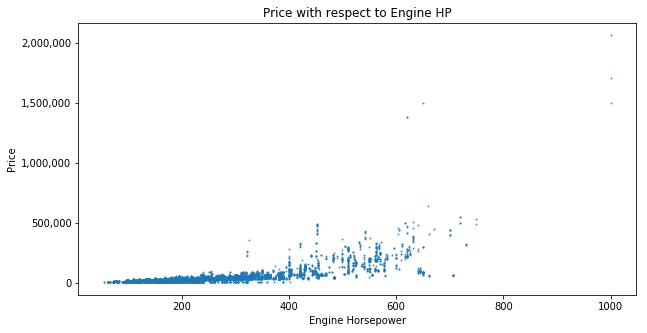

In [103]:
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker

# Price in function of the Engine HP
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(df['Engine HP'], df['Price'], s=1, alpha=0.7)

# Set title and axis
plt.title('Price with respect to Engine HP')
plt.xlabel('Engine Horsepower')
plt.ylabel('Price')

# Thousands separator for the y-axis
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

We can clearly see an exponential relationship between those variables. In the 'features engineering' section we'll talk more about it, and we'll see which power of the variable (logarithmic, square, exponential) offers the best correlation.

In [22]:
# We split the dataset for data-visualization purpose 
# The price distribution is strongly right-skewed
df_viz = df.loc[df['Price'] <= 100000]  # contains 95% of the values
df_hypercar = df.loc[df['Price'] > 100000]

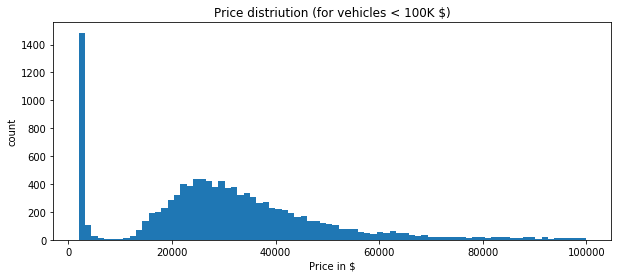

In [23]:
# Price distribution
plt.figure(figsize=(10, 4))
plt.hist(df_viz['Price'], bins=80)

plt.title('Price distriution (for vehicles < 100K $)')
plt.xlabel('Price in $')
plt.ylabel('count')
plt.show()

Interestingly enough, prices are not normally distributed : beside the overall right-tail skewness of the price variable, we can note a whole group of cars competing on the low-price segment of the market.

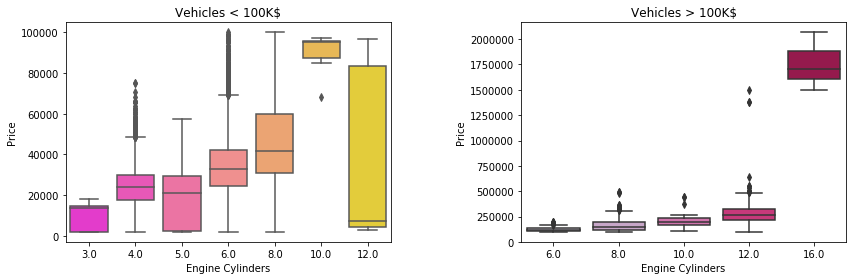

In [24]:
# Range of price depending on the engine size
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# We make 2 plots according to the price-category
sns.boxplot(x='Engine Cylinders', y='Price', data=df_viz, 
            ax=axes[0], palette="spring").set_title('Vehicles < 100K$')

sns.boxplot(x='Engine Cylinders', y='Price', data=df_hypercar, 
            ax=axes[1], palette="PuRd").set_title('Vehicles > 100K$')

plt.tight_layout()
plt.subplots_adjust(wspace = 0.4)
plt.show()

As expected the price moves along with the number of engine cylinders. Once again, it seems a linear relationship might not be the best to explain the variability of the price, based on the number of engine cylinders. Some feature engineering will be used as well.

However, the range of values taken by the 12-cylinders vehicles (for cars pricing below 100 000$) is surprisingly spread out.

Analysing this kind of vehicles shows that the low values (3000 - 7500$) correspond to old BMW and Mercedes from the 90's, but a few Volkswagen Phaeton are selling at 80K - 100K , hence the variability in price.

In [25]:
# 2 cheapest and most expensive 12-cylinders vehicles
df_viz[df_viz['Engine Cylinders'] == 12].iloc[np.r_[0:2, -2:0]]

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,Highway L/100km,City L/100km,Popularity,Price,Age
670,Mercedes-Benz,600-Class,1992,regular unleaded,402,12.0,AUTOMATIC,rear wheel drive,4.0,Luxury,Large,Sedan,16.79,23.50,617,2960,25
671,Mercedes-Benz,600-Class,1993,regular unleaded,389,12.0,AUTOMATIC,rear wheel drive,4.0,Luxury,Large,Sedan,15.67,21.36,617,3108,24
7546,Volkswagen,Phaeton,2005,premium unleaded (recommended),420,12.0,AUTOMATIC,all wheel drive,4.0,"Luxury,Performance",Large,Sedan,13.82,21.36,873,96100,12
7550,Volkswagen,Phaeton,2006,premium unleaded (required),444,12.0,AUTOMATIC,all wheel drive,4.0,"Luxury,Performance",Large,Sedan,13.82,21.36,873,96600,11


__Features Engineering__

- Correlation analysis

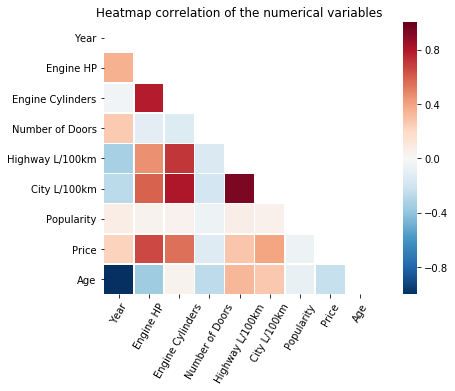

In [26]:
# Heatmap correlation between the variables

corr_map = df.corr()

# Mask for the upper triangle
mask = np.zeros_like(corr_map, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask
f, ax = plt.subplots(figsize=(10, 5))

sns.heatmap(corr_map, mask=mask, cmap='RdBu_r', vmax=1, center=0, 
            square=True, linewidths=.5, ax=ax)

plt.xticks(rotation='60')
plt.title('Heatmap correlation of the numerical variables')

plt.show()

In [27]:
# Correlation table
df.corr()

,Year,Engine HP,Engine Cylinders,Number of Doors,Highway L/100km,City L/100km,Popularity,Price,Age
Year,1.000000,0.353345,-0.032725,0.262659,-0.328514,-0.270576,0.072678,0.227569,-1.000000
Engine HP,0.353345,1.000000,0.781364,-0.102205,0.454313,0.587292,0.035649,0.662392,-0.353345
Engine Cylinders,-0.032725,0.781364,1.000000,-0.136513,0.716284,0.809878,0.045831,0.547048,0.032725
Number of Doors,0.262659,-0.102205,-0.136513,1.000000,-0.148169,-0.180514,-0.049396,-0.127644,-0.262659
Highway L/100km,-0.328514,0.454313,0.716284,-0.148169,1.000000,0.941064,0.069868,0.275555,0.328514
City L/100km,-0.270576,0.587292,0.809878,-0.180514,0.941064,1.000000,0.051949,0.395896,0.270576
Popularity,0.072678,0.035649,0.045831,-0.049396,0.069868,0.051949,1.000000,-0.048419,-0.072678
Price,0.227569,0.662392,0.547048,-0.127644,0.275555,0.395896,-0.048419,1.000000,-0.227569
Age,-1.000000,-0.353345,0.032725,-0.262659,0.328514,0.270576,-0.072678,-0.227569,1.000000


As we can see there is a very strong correlation between the variables 'City L/100km' and 'Highway L/100km' (0.94). It make sense as they both measure the vehicle fuel consumption, which is likely to be proportional in both situations.

We can also note the perfect negative correlation (-1) between the age and the year, which is perfectly normal as the 'Age' parameter derive from the Year.


The 5 key assumptions for using Linear Regresion are :

    . Linear relationship
    . Multivariate normality
    . No or little multicollinearity
    . No auto-correlation
    . Homoscedasticity

Multicollinearity is the correlation among variables. The ones we just talked about contradict this assumption. 
Additionnally, the correlation table indicates that the City L/100km fuel consumption is a better indicator for the vehicle price than the Highway L/100km.
Finally, the Year parameter is redundant with the Age of a vehicle. 

Therefore we'll drop the 'Highway L/100km' and 'Year' variables.

In [28]:
df = df.drop(columns=['Year', 'Highway L/100km'], axis=1)

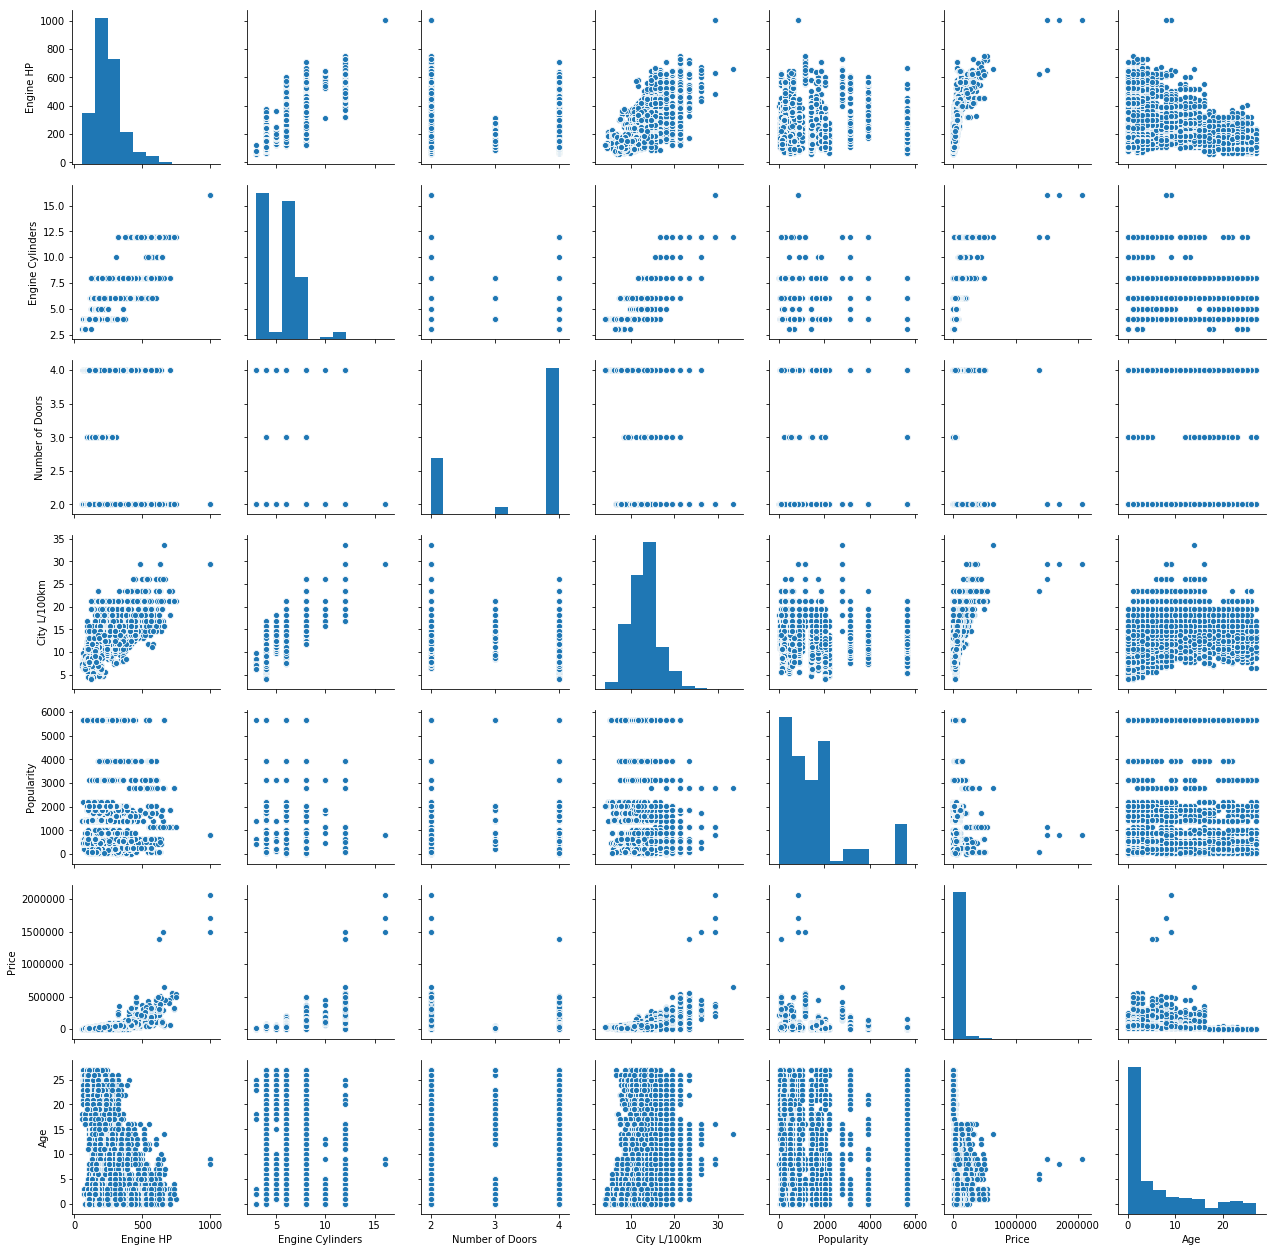

In [29]:
# Pairplot to observe the relationship between variables
sns.pairplot(df)

plt.show()

We said earlier that the prices were so right-skewed we had to split the dataset to have meaningful plots. Add to this, we can see on the pairplot graph that the price often has an exponential relationship with the other variables (especially Engine HP, Engine Cylinder, City L/100km).

Therefore, we'll log tranform the price variable, and later compute the correlation coefficients between log(price) and different power (square root, log, square) of the other numerical variables.

Finally, the number of doors seems to be more appropriate if used as a categorical variable, therefore we won't use it in our regression model.

In [30]:
# Log transform the price
df['Log_price'] = df['Price'].apply(lambda x : np.log(x+1))

In [31]:
# Several powers of the variable

# Engine HP
df['Sq_engine_hp'] = df['Engine HP'].apply(lambda x : np.square(x))
df['Sqrt_engine_hp'] = df['Engine HP'].apply(lambda x : np.sqrt(x))
df['Log_engine_hp'] = df['Engine HP'].apply(lambda x : np.log(x+1))

# Correlation table
corr = df.corr()
corr[['Price', 'Log_price']].loc[['Engine HP', 'Sq_engine_hp', 
                                  'Sqrt_engine_hp', 'Log_engine_hp'], :]

,Price,Log_price
Engine HP,0.662392,0.680113
Sq_engine_hp,0.743719,0.623111
Sqrt_engine_hp,0.609975,0.692852
Log_engine_hp,0.552919,0.693258


The strongest correlation with the Log_price variables is when using Log_engine_hp (0.693). We'll drop the other functions of Engine HP.

In [32]:
# Age
df['Sq_age'] = df['Age'].apply(lambda x : np.square(x))
df['Sqrt_age'] = df['Age'].apply(lambda x : np.sqrt(x))
df['Log_age'] = df['Age'].apply(lambda x : np.log(x+1))

# Correlation table
corr = df.corr()
corr[['Price', 'Log_price']].loc[['Age', 'Sq_age', 'Sqrt_age', 'Log_age'], :]

,Price,Log_price
Age,-0.227569,-0.768184
Sq_age,-0.246195,-0.820073
Sqrt_age,-0.185399,-0.663697
Log_age,-0.163754,-0.603754


The square of the Age variable is much more correlated with Log_price than it was when the variables weren't tranformed (-0.82 vs -0.22). Therefore, we keep Sq_age.

In [33]:
# City L/100km
df['Sq_city'] = df['City L/100km'].apply(lambda x : np.square(x))
df['Sqrt_city'] = df['City L/100km'].apply(lambda x : np.sqrt(x))
df['Log_city'] = df['City L/100km'].apply(lambda x : np.log(x+1))

corr = df.corr()
corr[['Price', 'Log_price']].loc[['City L/100km', 'Sq_city', 'Sqrt_city', 'Log_city'], :]

,Price,Log_price
City L/100km,0.395896,0.151824
Sq_city,0.458524,0.170509
Sqrt_city,0.363130,0.141367
Log_city,0.334592,0.131878


We'll choose the Sq_city column, which enables to maximize the correlation coefficient with Log_price.

In [34]:
# Drop the unused columns
df = df.drop(['Sq_engine_hp', 'Sqrt_engine_hp', 'Sqrt_age', 
              'Log_age', 'Sqrt_city', 'Log_city'], axis=1)

To conclude, the numerical variables we'll use for our model are : Log_price, Log_engine_hp, Sq_age, Sq_city.

In [35]:
df.loc[:,['Log_price', 'Log_engine_hp', 'Sq_age', 'Sq_city']].head()

,Log_price,Log_engine_hp,Sq_age,Sq_city
0,10.739349,5.817111,36,153.0169
1,10.612779,5.707110,36,153.0169
2,10.500977,5.707110,36,138.0625
3,10.290483,5.442418,36,170.5636
4,10.448744,5.442418,36,170.5636


__Modeling__

- Simple Linear Regression

In [36]:
# Defining our features X and target variable Y
X = df[['Log_engine_hp']]
Y = df[['Log_price']]

# Split the data set into a train and test set
# We use 60% of the dataset for the training and 40% for testing
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.4, random_state=53)

In [37]:
# SLR with only 1 feature : Log_engine_hp
lr = LinearRegression()

lr.fit(xtrain, ytrain)

#print('The slope is ', lr.coef_)
print('The slope is ', '{0:.4f}'.format(lr.coef_.item()))

print('The intercept is ', '{0:.4f}'.format(lr.intercept_.item()))

The slope is  1.8337
The intercept is  0.1524


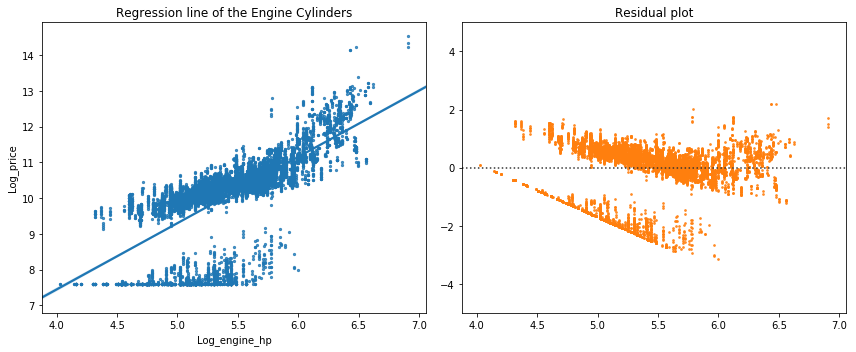

In [38]:
# Graph of the prediction line and its residual error

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 5))

ax1= sns.regplot(x='Log_engine_hp', y='Log_price', data=df, scatter_kws={"s": 5}, ax=ax1)
ax1.set_title('Regression line of the Engine Cylinders')

ax2 = sns.residplot(X, Y, scatter_kws={"s": 3}, ax=ax2)
ax2.set_title('Residual plot')
ax2.set_ylabel('')
ax2.set_ylim(-5, 5)

plt.tight_layout()
plt.show()

As we can see we have room for improvement, but log-transforming these features revealed itself to be necessary to use the Linear Regression.

In [39]:
# Make a cross-validation on 4 substets
score = cross_val_score(lr, xtrain, ytrain, cv=4) # score on 4 partitions

print('The cross-validations sets R-squared are :', score)
print('The average performance is therefore', np.mean(score))

The cross-validations sets R-squared are : [0.50410061 0.45504412 0.4543677  0.50156789]
The average performance is therefore 0.47877008082437794


In [40]:
# Let's make some predictions

yhat_simple = cross_val_predict(lr, xtest, ytest, cv=4)
print('The 1st prediction is', round(np.exp(yhat_simple[0].item())), 'whereas the actual value was', df.Price[0])

The 1st prediction is 75523.0 whereas the actual value was 46135


In [41]:
# Model evaluation
simple_linear_R2_train = lr.score(xtrain, ytrain)
simple_linear_R2_test = lr.score(xtest, ytest)

# We backtransform yhat_simple to perform a MSE test
s_linear_MSE = mean_squared_error(ytest, np.exp(yhat_simple))

print('Simple Linear Regression')

print('Mean Squared Error', s_linear_MSE)
print('R-squared on train data', simple_linear_R2_train)
print('R-squared on test data', simple_linear_R2_test)

Simple Linear Regression
Mean Squared Error 1919194747.8500288
R-squared on train data 0.47975445460523986
R-squared on test data 0.4810411289405628


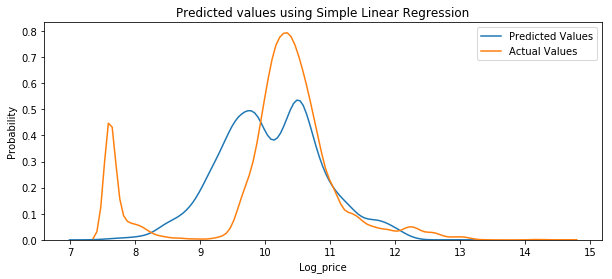

In [42]:
# Distribution graph of the actual and predicted values

plt.figure(figsize=(10, 4))

ax1 = sns.distplot(yhat_simple, hist=False, label='Predicted Values')
sns.distplot(df['Log_price'], hist=False, label='Actual Values', ax=ax1)

plt.ylabel('Probability')
plt.legend()
plt.title('Predicted values using Simple Linear Regression')

plt.show()

The distribution graph assess that this simple linear model tends to underestimate the true proportion of the vehicles of the low-price range (the peak of distribution for the cars pricing around 3000$).

A simple linear regression model is also blind to the premium segment (cars above 270 000$ (exp(12.5)).

- Polynomial Regression

In [43]:
# Function for graphing a polynomial regression model approximation

def PlotPoly(model, independant_var, dependant_var):
    
    # Calculate the polynomial function for 100 points
    new_x = np.linspace(min(df[independant_var]), max(df[independant_var]), 1000)
    y_model = model(new_x)
    
    # Graph of the data points and the polynomial line
    plt.figure(figsize=(10, 5))
    plt.plot(X[independant_var], df[dependant_var], '.', markersize=1)
    plt.plot(new_x, y_model, '-')
    
    # Axis label and x-axis setting
    plt.xlabel(independant_var)
    plt.ylabel('Price')

    plt.show()
    plt.close()

In [44]:
# Set variables
X = df[['Engine HP']]
Y = df[['Price']]
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.4, random_state=53)

# Compute a polynomial function of order 3
f = np.polyfit(xtrain['Engine HP'], ytrain['Price'], 3)
p = np.poly1d(f)   # our model

print('Polynomial function of the Engine Horsepower :', '\n')
print(p)

Polynomial function of the Engine Horsepower : 

          3        2
0.003246 x - 2.27 x + 675.2 x - 4.391e+04


In [45]:
# Prediction
yhat_simple_poly = p(xtest)

print('Prediction', round(yhat_simple_poly[0].item()))
print('Actual value', df['Price'][0])

Prediction 79721
Actual value 46135


In [46]:
# Model Evaluation
poly_R2_test = r2_score(ytest, yhat_simple_poly)

s_poly_MSE = mean_squared_error(ytest, yhat_simple_poly)

print ('Polynomial Regression')
print('R-square on the test data', poly_R2_test)
print('Mean Squared Error', s_poly_MSE)

Polynomial Regression
R-square on the test data 0.6209147479532966
Mean Squared Error 1081695249.4425282


The Polynomial regression model is a better predictor of the price of a vehicle than using Simple Linear regression (SLR). Indeed, we can see that its R-squared score is higher than the SLR one (0.638 vs 0.482), meaning that it can explain more variability in the data.

A R-squared of 0.64 means our model can assess up to 64% of the variation in the car price.

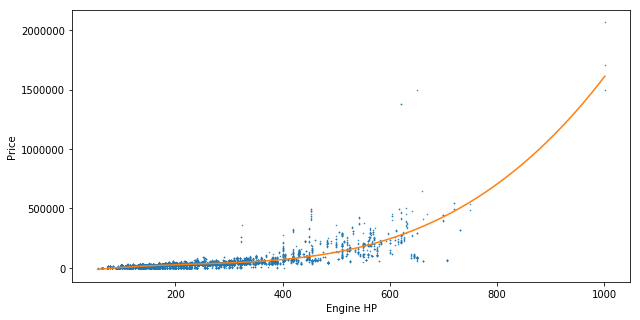

In [47]:
# Graph of our polynomial regression line
PlotPoly(p, 'Engine HP', 'Price')

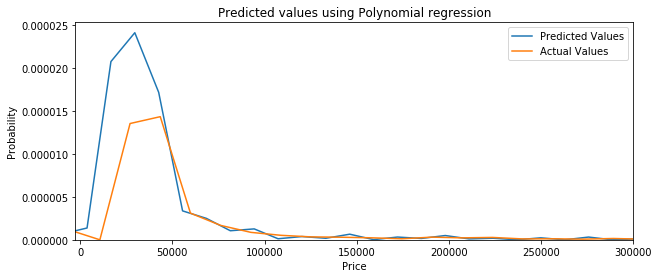

In [48]:
# Distribution graph of the actual and predicted values
plt.figure(figsize=(10, 4))

ax1 = sns.distplot(yhat_simple_poly, hist=False, label='Predicted Values')
sns.distplot(Y, hist=False, label='Actual Values', ax=ax1)

# Set title, labels, axis
plt.title('Predicted values using Polynomial regression')
plt.xlim(-2500, 300000)
plt.xlabel('Price')
plt.ylabel('Probability')
plt.legend()

plt.show()

Our model tends to highly over-estimate the true proportion of cars below 35K US$.

- Multiple Linear Regression

In [49]:
# Linear regression with multiple features
lm = LinearRegression()

Z = df[['Log_engine_hp', 'Sq_age', 'Sq_city']]
Y = df['Log_price']

# Train / Test split
ztrain, ztest, ytrain, ytest = train_test_split(Z, Y, test_size=0.4, random_state=53)

lm.fit(ztrain, ytrain)

print('Coefficient for each variable', lm.coef_)
print('Intercept term :', lm.intercept_)

Coefficient for each variable [ 0.90920629 -0.00441264  0.00132075]
Intercept term : 5.376278121288255


In [50]:
# Prediction
yhat_multi = lm.predict(ztest)
print('Prediction :', round(np.exp(yhat_multi[0].item()), 0))
print('Actual value:', df.Price[0])

Prediction : 35243.0
Actual value: 46135


In [51]:
# Model evaluation
m_linear_R2 = lm.score(ztrain, ytrain)
# We backtransform yhat_multi
m_linear_MSE = mean_squared_error(ytest, np.exp(yhat_multi))

print ('Multiple Linear Regression')
print( 'Mean Squared Error', m_linear_MSE)
print('R-squared', m_linear_R2)

Multiple Linear Regression
Mean Squared Error 1786978083.404112
R-squared 0.8364315161842266


Using 3 variables instead of a single one seems to do a way better job in term of prediction. The R-squared score of this model indicate that we can explain nearly 84% of the price variation, which is a huge improvment compare to the Simple linear regression (48%) or the polynomial regression with 1 feature (64%).

Let's have a look at the distribution plot to see if our approximation distribution is more similar to the empirical data one.


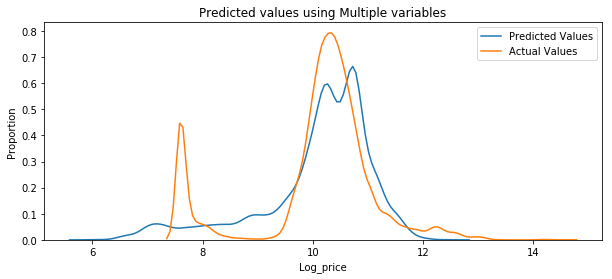

In [52]:
# Distribution graph of the actual and predicted values

plt.figure(figsize=(10, 4))

ax1 = sns.distplot(yhat_multi, hist=False, label='Predicted Values')
sns.distplot(Y, hist=False, label='Actual Values', ax=ax1)

plt.ylabel('Proportion')
plt.legend()
plt.title('Predicted values using Multiple variables')

plt.show()

Now we begin to notice clear improvement : we have a fair estimation of the cars pricing over 22000 dollars (e^10)). However, our model still struggles to predict the actual price of the low-cost vehicles with accuracy (especially automobiles around 1800$ (e^7.5)).

- Polynomial regression with Muliple Variables

As we say a simple linear regression model wasn't enought to approximate the actual function we want to predict. Therefore we'll now build a more complex model and see if we can achieve better results. 

In [53]:
# Set the parameters
Z = df[['Engine HP', 'Age', 'City L/100km']]
Y = df['Price']

ztrain, ztest, ytrain, ytest = train_test_split(Z, Y, test_size=0.4, random_state=53)

# Create and train the pipeline
Input = [('scale', StandardScaler()), ('polynomial', PolynomialFeatures(degree=3)), ('model', LinearRegression())]

pipe = Pipeline(Input)
pipe.fit(ztrain, ytrain)

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomial', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [54]:
# Prediction with the pipeline
yhat_poly_multi = pipe.predict(ztest)

print('Prediction :', round(yhat_poly_multi[0].item(), 0))
print('Actual value :', df.Price[0])

Prediction : 146965.0
Actual value : 46135


In [55]:
# Model Evaluation
m_poly_R2 = r2_score(ytest, yhat_poly_multi)
m_poly_MSE = mean_squared_error(ytest, yhat_poly_multi)

print ('Multivariable Polynomial Regression')
print( 'Mean Squared Error', m_poly_MSE)
print('R-square', m_poly_R2)

Multivariable Polynomial Regression
Mean Squared Error 676612928.4691759
R-square 0.762877776657534


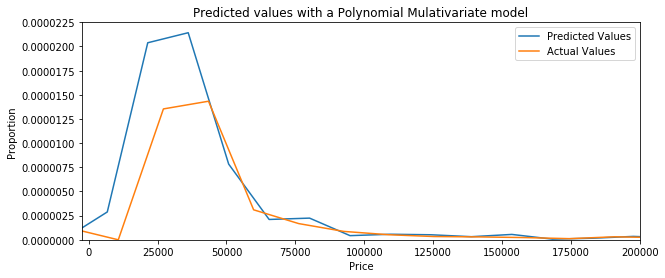

In [56]:
# Distribution graph of the actual and predicted values

plt.figure(figsize=(10, 4))

ax1 = sns.distplot(yhat_poly_multi, hist=False, label='Predicted Values')
sns.distplot(df['Price'], hist=False, label='Actual Values', ax=ax1)

plt.xlim(-2500, 200000)
plt.ylabel('Proportion')
plt.legend()
plt.title('Predicted values with a Polynomial Mulativariate model')

plt.show()

This model was build with a polynomial function of order 3, but it si not obvious that this degree of polynomial is the one giving the most accurate predictions. Let's measure the accuracy of other polynomial functions.

In [57]:
# Test different orders of polynomials

# Setting the parameters
Z = df[['Engine HP', 'Age', 'City L/100km']]
Y = df['Price']
ztrain, ztest, ytrain, ytest = train_test_split(Z, Y, test_size=0.4, random_state=53)

order = np.arange(0, 7)
r_squared_poly = []

# Linear regression of degree n
for n in order :
    # Create & train the pipe
    Input = [('scale', StandardScaler()), ('polynomial', PolynomialFeatures(degree=n)), 
             ('model', LinearRegression())]
    
    pipe = Pipeline(Input)
    pipe.fit(ztrain, ytrain)
    
    # Make predictions on the test data
    z_test_pr = pipe.predict(ztest)
    
    #Compute the r-squared
    r_squared_poly.append(r2_score(ytest, z_test_pr))

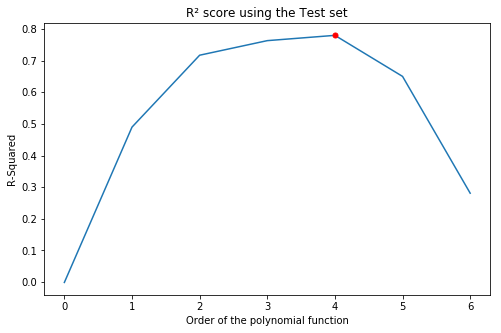

In [58]:
# Graph of the R-squared for each degree n
plt.figure(figsize=(8, 5))

plt.plot(order, r_squared_poly)

# Dot at the maxima of the curve
max_order = order[r_squared_poly.index(max(r_squared_poly))]
max_r2 = max(r_squared_poly)
ax = plt.plot(max_order, max_r2, '.', markersize=10, c='r')

plt.xlabel('Order of the polynomial function')
plt.ylabel('R-Squared')
plt.title('R² score using the Test set')

plt.show()

In [59]:
max(r_squared_poly)

0.7795855920541972

Our predictive model attains its maximal efficiency when we use a polynomial function of order 4. It then achieves to obtain a 0.78 R-squared score. A higher degree function doesn't help or enhance the predictability of the vehicles price : the decreasing curve after n=4 shows that more complex functions will overfit the data.
It's interesting to note that using polynomials didn't increase the R-squared score compare to using a linear model with the sames parameters.

However, the mean squared error figure was very highly improved when using a polynomial function : 1,05 bn vs 1,78 bn

Overall, the best model we came up with, with respect to r-squared is the Multivariate Linear Regression (0.84), but the leader in term of mean squared error was the Multivariate Polynomial Regression (1,05 bn).

The magnitude by which the Polynomial outperforms the Linear model on the MSE metrics is so large that we might consider it as the most accurate model, even if it is only the 2nd in term of R-squared score.